In [2]:
import sys

# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
# from DA_PoC.dynamical_systems.examples.lorenz96 import Lorenz96Model
# from DA_PoC.dynamical_systems.examples.lorenz63 import Lorenz63Model
# from DA_PoC.common.numerical_model import NumericalModel
from common.observation_operator import (
    RandomObservationOperator,
    IdentityObservationOperator,
)
from dynamical_systems.lorenz_numerical_model import (
    LorenzWrapper,
    create_lorenz_model_observation,
    burn_model
)
from variational.gauss_newton_VarDA import data_assimilation, diagnostic_plots, plot_innerloopiter

ValueError: attempted relative import beyond top-level package

Text(0.5, 1.0, 'R_half')

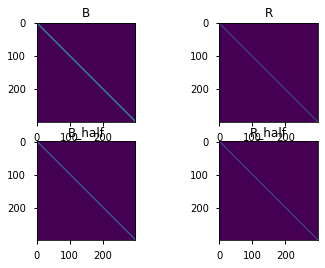

In [6]:
rng = np.random.default_rng(seed=93)

n = 100 
lorenz = LorenzWrapper(n)
lorenz.lorenz_model.dt = 0.01
assimilation_window = [0.05, 0.4, 0.6, 0.8] # 6 hours, 48 hours, 72 hours, 96 hours
F = 8
assimilation_window_timesteps = [int(wind / lorenz.lorenz_model.dt) for wind in assimilation_window]

sigma_b_sq = (0.04 * F)**2 + (0.1 * np.abs(0 - F))**2
charac_length = 1.5
background_correlation = lambda x, y: np.exp(-(x-y)**2 / charac_length**2)
x, y = np.meshgrid(np.arange(n), np.arange(n))
B = sigma_b_sq * background_correlation(x, y)
B_half = np.linalg.cholesky(B)
sigma_obs_sq = (0.04 * F)**2 + (0.1 * np.abs(0 - F))**2
R = sigma_obs_sq * np.eye(n)
R_half = np.linalg.cholesky(R)
plt.subplot(2, 2, 1)
plt.imshow(B)
plt.title('B')
plt.subplot(2, 2, 2)
plt.imshow(R)
plt.title('R')
plt.subplot(2, 2, 3)
plt.imshow(B_half)
plt.title('B_half')
plt.subplot(2, 2, 4)
plt.imshow(R_half)
plt.title('R_half')


In [4]:
lorenz = LorenzWrapper(n)
lorenz.H = lambda x: x
x0_t = burn_model(n, 14400)

In [7]:
history = lorenz.lorenz_model.integrate(0, x0_t, assimilation_window_timesteps[-1])

In [16]:
tlm = lorenz.lorenz_model.construct_tlm_matrix(0, x0_t, assimilation_window_timesteps[-1])

In [17]:
tlm.shape

(300, 81, 300)

In [ ]:

def get_next_observations(x_init, lorenz=lorenz, modsigsq=0.5, obssigsq=3, nobs=nobs):
    lorenz.n_total_obs = nobs
    n = lorenz.state_dimension
    truth = np.empty((n, nobs + 1))
    curr_state = x_init
    truth[:, 0] = curr_state
    for i in range(nobs):
        curr_state = lorenz.lorenz_model.integrate(0, curr_state, 1)[1][
            :, 1
        ] + modsigsq * np.random.normal(size=(n))
        truth[:, i + 1] = curr_state
    obs = truth + obssigsq * np.random.normal(size=(n, (nobs + 1)))
    x_t = truth[:, -1]
    return obs, x_t, truth



In [ ]:
print(f"Random observation operator   ---------------")
m = n * (nobs + 1)

random_obs_operator = IdentityObservationOperator(m, m)  # , 0.9, 0)
random_obs_operator = RandomObservationOperator(m, m, type="rect", p=1, p_offdiag=0)

# plt.imshow(random_obs_operator.H)
# m = n * (nobs + 1)
l_model_randobs = create_lorenz_model_observation(
    lorenz, m, random_obs_operator, test=False
)


In [ ]:
n_cycle = 2
n_outer = 10
n_inner = 50
# np.random.set_state(7071522)
DA_vanilla = data_assimilation(
    l_model_randobs,
    random_obs_operator,
    get_next_observations,
    n_cycle,
    n_outer,
    n_inner,
    prec=None,
    plot=False,
)
diagnostic_plots(DA_vanilla, "vanilla")


In [ ]:
l_model_randobs.r = n // 10
DA_LMP_10 = data_assimilation(
    l_model_randobs,
    random_obs_operator,
    get_next_observations,
    n_cycle,
    n_outer,
    n_inner,
    prec="spectralLMP",
    plot=False,
)
diagnostic_plots(DA_LMP_10, "LMP 10")

In [ ]:
l_model_randobs.r = n // 20
DA_LMP_5 = data_assimilation(
    l_model_randobs,
    random_obs_operator,
    get_next_observations,
    n_cycle,
    n_outer,
    n_inner,
    prec="spectralLMP",
    plot=False,
)
diagnostic_plots(DA_LMP_5, "LMP 5")

In [ ]:
l_model_randobs.r = n // 50
DA_LMP_2 = data_assimilation(
    l_model_randobs,
    random_obs_operator,
    get_next_observations,
    n_cycle,
    n_outer,
    n_inner,
    prec="spectralLMP",
    plot=False,
)
diagnostic_plots(DA_LMP_2, "LMP 2")


In [ ]:
plot_innerloopiter(DA_vanilla, "blue", "vanilla")
plot_innerloopiter(DA_LMP_10, "red", "LMP 10")
plot_innerloopiter(DA_LMP_5, "magenta", "LMP 5")
plot_innerloopiter(DA_LMP_2, "grey", "LMP 2")
plt.legend()
